### Storing the `MovieLens 25M Dataset` to Neo4j

#### Imports

In [1]:
import pathlib
import os
from os.path import join
from py2neo import Graph, Node, Relationship
from py2neo.bulk import merge_nodes
import pandas as pd

#### Connecting to the neo4j instance

In [2]:
graph = Graph(
    "bolt://localhost:11005",
    auth=("neo4j", "admin"),
)

#### Some helpers fot storing the dataset to `neo4j`

##### General helpers

In [3]:
def read_csv(filename: str):
    db_directory_path = pathlib.Path(os.getcwd()).parent.absolute()
    data_directory_path = join(db_directory_path, "data")
    file_path = join(data_directory_path, f"{filename}.csv")
    print("Reading from:", file_path)
    df = pd.read_csv(file_path)
    return df

def df_to_json(df):
    return df.to_dict("records")

def get_movie_year(movie: Node):
    title = movie["title"]
    try:
        year = int(title[-5:-1])
    except Exception as e:
        print(e)
    return year

def remove_year_from_title(movie: Node):
    try:
        year = get_movie_year(movie)
        return movie["title"].replace(f" ({year})", "")
    except Exception as e:
        print(e)
    return movie["title"]


##### Movies helpers

In [6]:
def insert_movies(movies, limit):
    merge_nodes(
        tx=graph.auto(),
        data=movies[:limit],
        merge_key=("Movie", "title"),
        labels={"Movie"}
    )

def create_attach_genre(movie, relationship, genre_name):
    genre = Node("Genre", name=genre_name)
    genre.__primarylabel__ = "Genre"
    genre.__primarykey__ = "name"
    graph.merge(relationship(movie, genre))

def insert_movie_genres(movie: Node):
    BELONGS_TO = Relationship.type("BELONGS_TO")
    genres = movie["genres"]
    genres_list = genres.split("|") if genres else []
    for genre_name in genres_list:
        create_attach_genre(movie, BELONGS_TO, genre_name)

def insert_movies_genres():
    movies = graph.nodes.match("Movie")
    for movie in movies:
        insert_movie_genres(movie)

def insert_movie_year(movie: Node):
    date = get_movie_year(movie)
    if date:
        PUBLISHED_IN = Relationship.type("PUBLISHED_IN")
        year = Node("Year", date=date)
        year.__primarylabel__ = "Year"
        year.__primarykey__ = "date"
        graph.merge(PUBLISHED_IN(movie, year))

def insert_movies_years():
    movies = graph.nodes.match("Movie")
    for movie in movies:
        insert_movie_year(movie)

def update_movies_titles():
    movies = graph.nodes.match("Movie")
    for movie in movies:
        movie["new_title"] = remove_year_from_title(movie)
        graph.push(movie)


#### Storing the movies in the database

* I store the following graph:
    * Nodes:
        * Movie
        * Genre
        * Year
    * Edges:
        * (Movie)-[BELONGS_TO]-(Genre)
        * (Movie)-[PUBLISHED_IN]-(Year)

In [7]:
MOVIES_LIMIT = 300

movies_df = read_csv("movies")
movies = df_to_json(movies_df)

insert_movies(movies, MOVIES_LIMIT)
insert_movies_genres()
insert_movies_years()
update_movies_titles()


Reading from: c:\Users\GiannisAthanasiou\Desktop\diploma\repo\diploma\movies_db\data\movies.csv


##### After storing the first 300 movies in the database

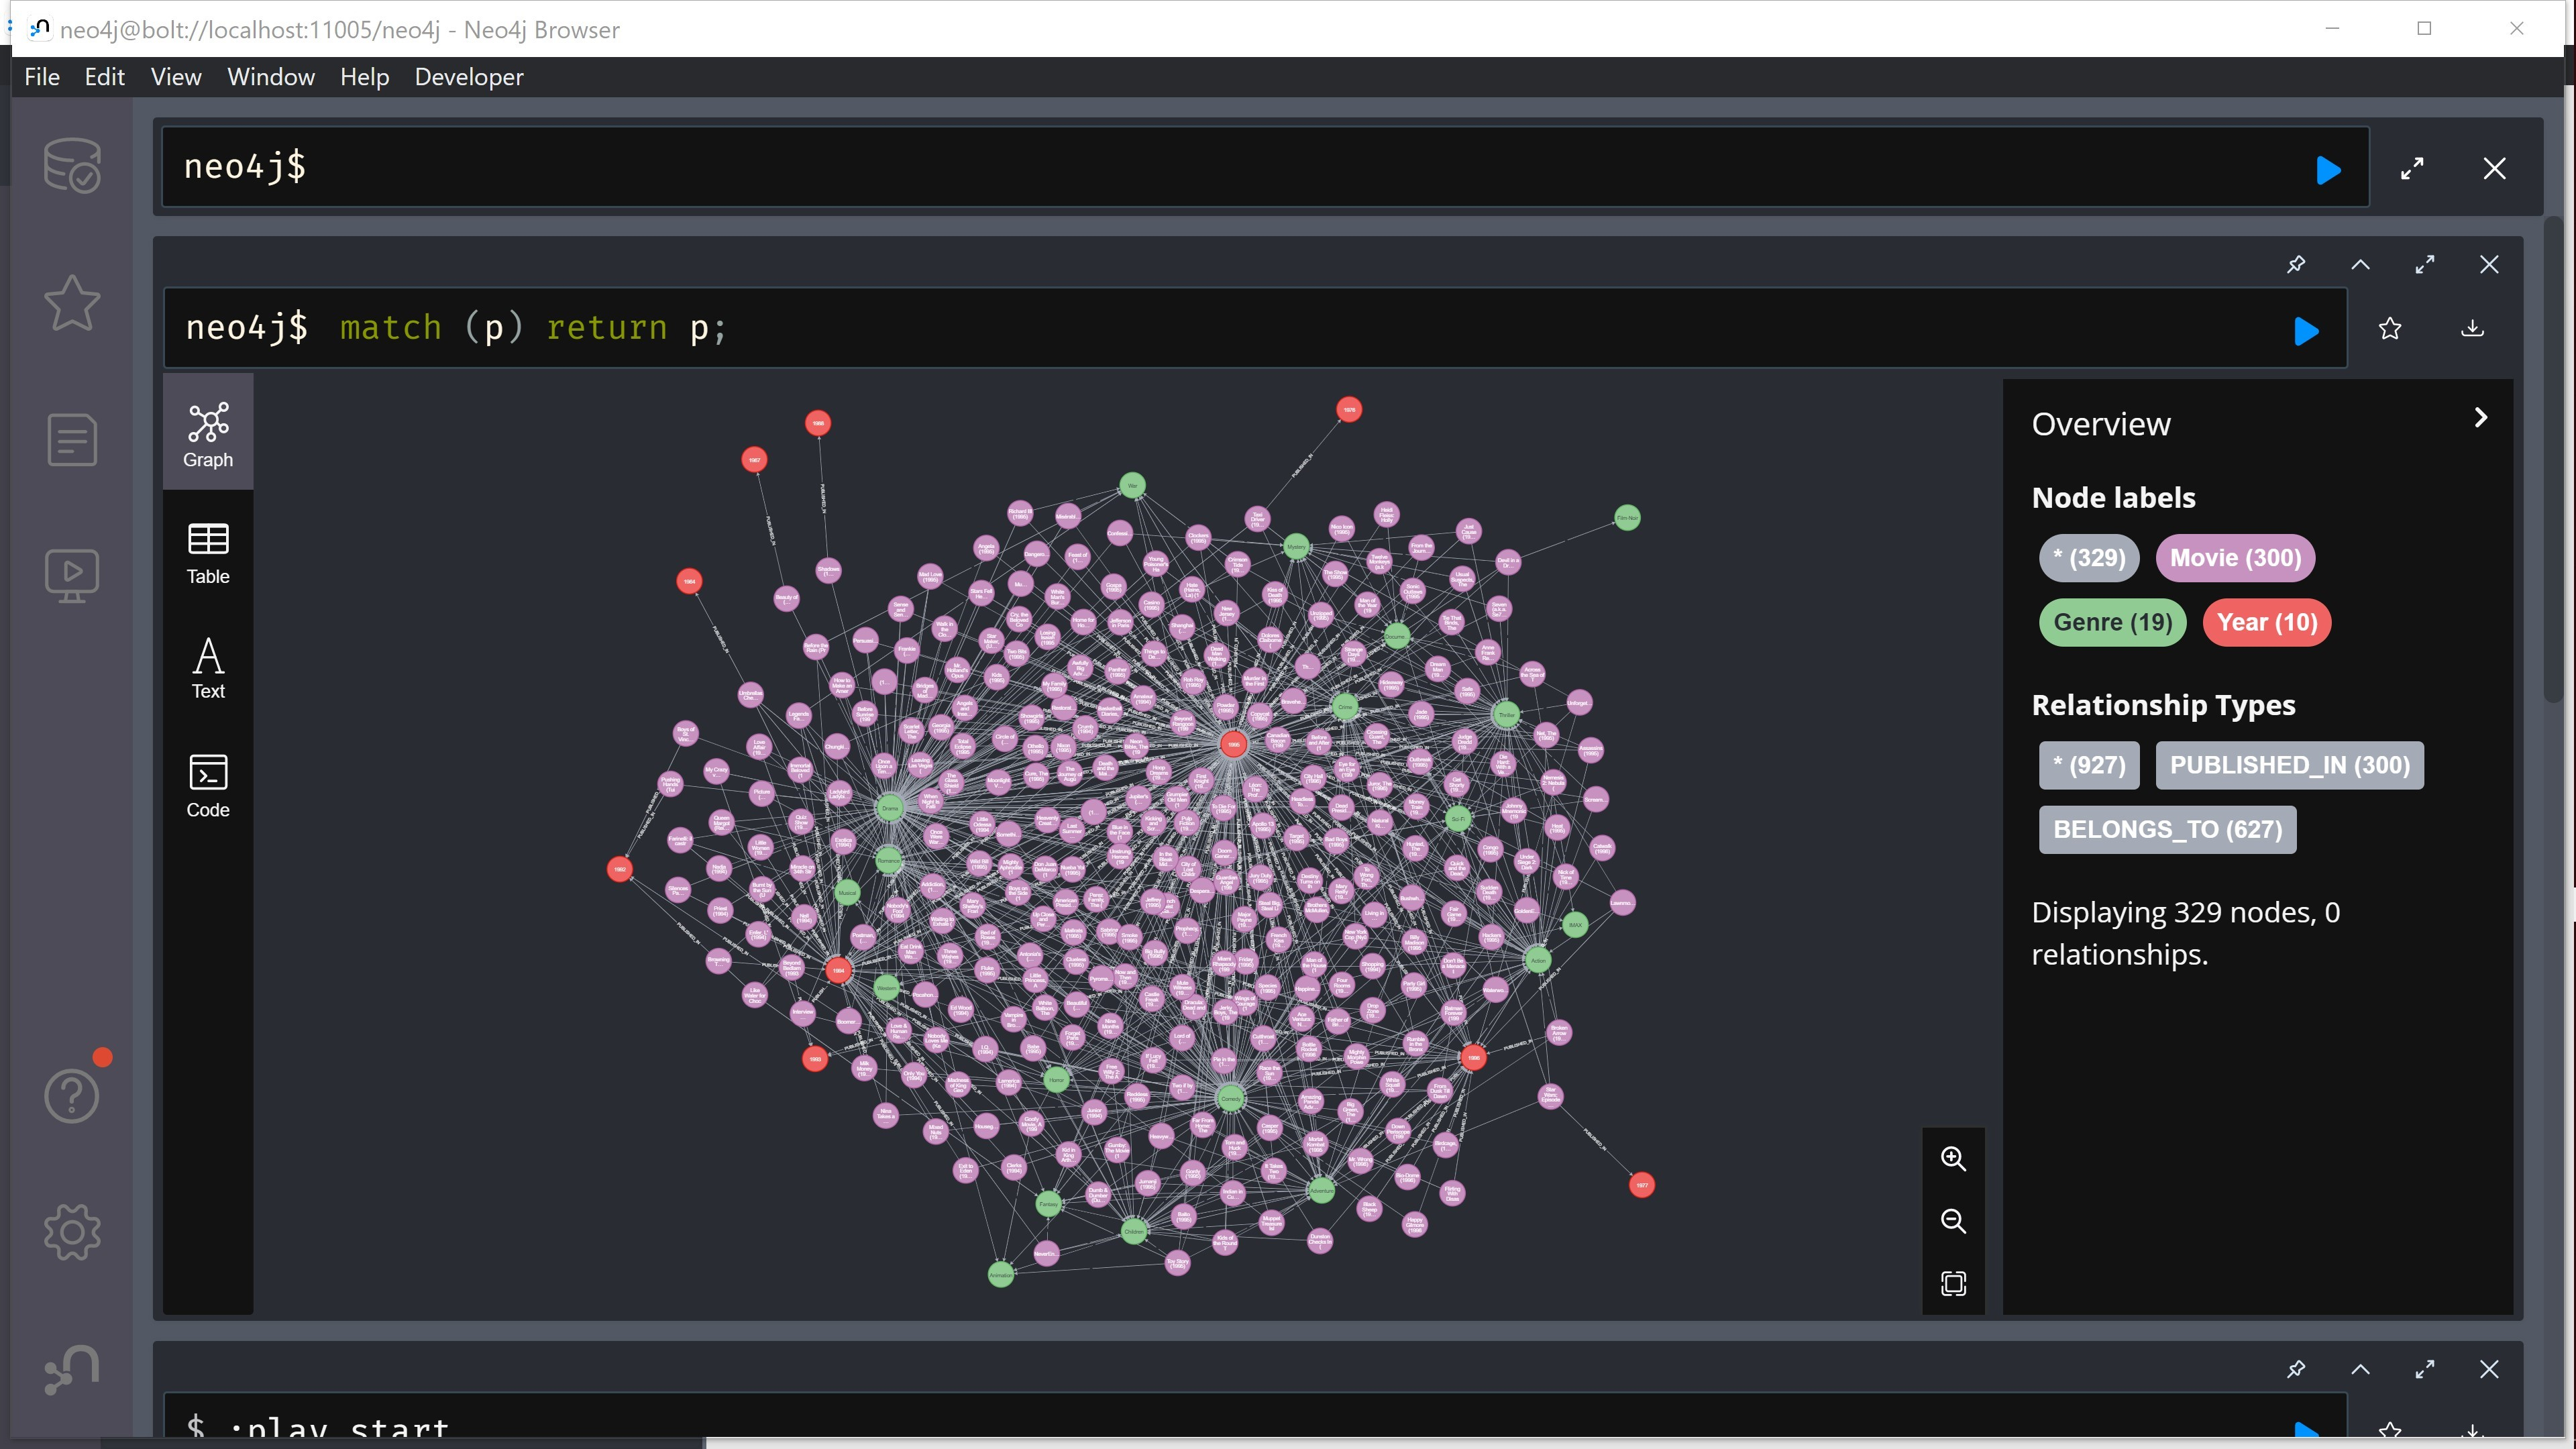

In [11]:
from IPython.display import Image
Image(filename='../images/300_movies.jpg') 